In [1]:
import functools
import sys

sys.path.append("./src")

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tqdm

import kfax

In [2]:
@functools.partial(jax.jit, static_argnums=[2])
def quaternion_rotate_point(quaternion, point, invert_rotation=False):
    vec = jax.lax.select(invert_rotation, -quaternion[0:3], quaternion[0:3])
    uv = jnp.cross(vec, point)
    uv += uv
    return point + quaternion[3] * uv + jnp.cross(vec, uv)


@jax.jit
def quaternion_inverse(q):
    return jnp.array([-q[0], -q[1], -q[2], q[3]])


@jax.jit
def quaternion_product(lhs, rhs):
    return jnp.array([
        lhs[3] * rhs[0] + lhs[0] * rhs[3] + lhs[1] * rhs[2] - lhs[2] * rhs[1],
        lhs[3] * rhs[1] + lhs[1] * rhs[3] + lhs[2] * rhs[0] - lhs[0] * rhs[2],
        lhs[3] * rhs[2] + lhs[2] * rhs[3] + lhs[0] * rhs[1] - lhs[1] * rhs[0],
        lhs[3] * rhs[3] - lhs[0] * rhs[0] - lhs[1] * rhs[1] - lhs[2] * rhs[2],
    ])


@functools.partial(jax.jit, donate_argnums=[0])
def dynamics(x, u):
    q = x[3:7]
    v = x[7:10]
    k_t = x[11]

    f = u[0]
    w = u[1:3]

    g = -9.81
    i3 = jnp.array([0, 0, 1])

    return jnp.concatenate([
        v,
        quaternion_product(q, jnp.append(w / 2, 0)),
        quaternion_rotate_point(q, k_t * f * i3) + g * i3,
        jnp.array([0.0]),
    ])


@jax.jit
def observation(x):
    p = x[0:3]
    v = x[7:10]
    return jnp.concatenate([p, v])


@functools.partial(jax.jit, donate_argnums=(0, 1))
def save_iter_data(x_est, kf_cov_est, x_op, kf_cov, k):
    return x_est.at[k, :].set(x_op), kf_cov_est.at[k, :, :].set(kf_cov)

In [5]:
data = jnp.load("./data/aer1517_example.npz")
t_vec = data["time"].squeeze()
dt = jnp.diff(t_vec)


v = jnp.c_[data["cmd"], data["angular_velocities"]]

x_true = jnp.c_[data["true_position"], data["true_orientation"], data["velocities"]]

in_cov = jnp.diag(jnp.r_[jnp.array([1]), jnp.full(3, 1e-2)])
obs_cov = jnp.diag(jnp.r_[jnp.full(3, 1e-1), jnp.full(3, 5e-1)])
kf = kfax.KalmanFilter(
    jax.jit(lambda x, u, dt: x + dt * dynamics(x, u)),
    jax.jit(observation),
    in_cov=in_cov,
    obs_cov=obs_cov,
)
x_op = jnp.append(x_true[0, :], 10.0)
kf_cov = jnp.diag(jnp.r_[jnp.full(3, 1), jnp.full(4, 0.1), jnp.full(3, 5), 10])

y = jnp.c_[data["positions"], data["velocities"]]

x_est = jnp.empty((len(t_vec), len(x_op))).at[0, :].set(x_op)

kf_cov_est = jnp.empty((len(t_vec), len(x_op), len(x_op))).at[0, :, :].set(kf_cov)

key = jax.random.PRNGKey(100)
has_meas = jax.random.randint(key, [t_vec.size], 0, 10) > 7

for k in tqdm.trange(1, t_vec.size):
    v_op = v[k, :]
    dt_op = dt[k - 1]

    x_op, kf_cov = kf.predict(x_op, kf_cov, v_op, dt_op)

    if has_meas[k]:
        y_op = y[k, :]
        x_op, kf_cov = kf.update(x_op, kf_cov, y_op)

    x_est, kf_cov_est = save_iter_data(x_est, kf_cov_est, x_op, kf_cov, k)

sigma3 = 3.0 * jnp.sqrt(jnp.diagonal(kf_cov_est, axis1=1, axis2=2))

  0%|          | 0/12485 [00:00<?, ?it/s]

100%|██████████| 12485/12485 [00:07<00:00, 1728.48it/s]


Text(0.5, 0.01, 'Time (s)')

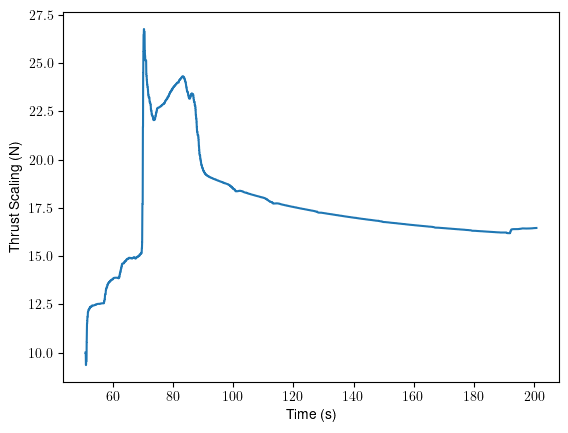

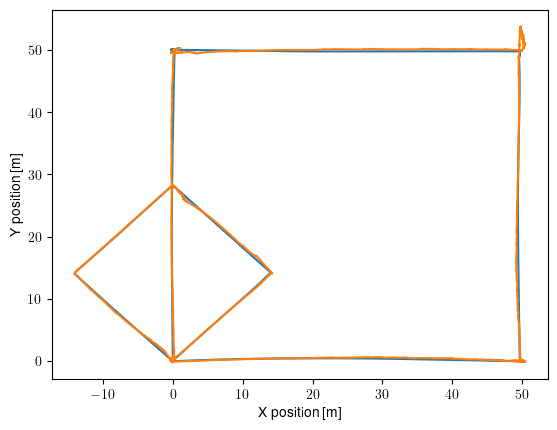

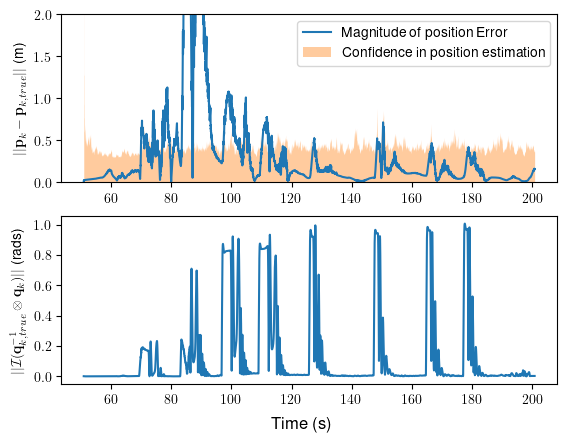

In [4]:
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})
fig = {}
fig[2], ax = plt.subplots()
ax.plot(t_vec, x_est[:, -1])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Thrust Scaling (N)")
fig[0], ax = plt.subplots()
ax.plot(x_true[:, 0], x_true[:, 1], label="Ground Truth")
ax.plot(x_est[:, 0], x_est[:, 1], label="Estimated")
ax.set_xlabel("X position [m]")
ax.set_ylabel("Y position [m]")

fig[1], ax = plt.subplots(nrows=2)
ax[0].plot(
    t_vec,
    jnp.linalg.norm(x_est[:, 0:2] - x_true[:, 0:2], axis=1),
    label="Magnitude of position Error",
)
ax[0].fill_between(
    t_vec[1:],
    jnp.linalg.norm(sigma3[1:, 0:2], axis=1),
    label=R"Confidence in position estimation",
    alpha=0.4,
    color="C1",
    linewidth=0,
)
ax[0].set_ylabel(r"$||\mathbf{p}_k - \mathbf{p}_{k, true}||$ (m)")
ax[0].set_ylim(0, 2)
ax[0].legend()


@jax.jit
def rotation_error(l, r):
    l = jnp.where(jnp.sign(l[3]) != jnp.sign(r[3]), -l, l)
    return 2 * quaternion_product(quaternion_inverse(l), r)


q_diff = jax.vmap(rotation_error)(x_true[:, 4:7], x_est[:, 4:7])
ax[1].plot(
    t_vec,
    jnp.linalg.norm(q_diff, axis=1),
    label="Magnitude of orientation Error",
)
ax[1].set_ylabel(
    r"$||\mathcal{I}(\mathbf{q}_{k, true}^{-1} \otimes \mathbf{q}_k)||$ (rads)"
)
fig[1].supxlabel("Time (s)")